### Описание эксперимента

Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом.  

Описание колонок:  
`value` – значения метрики  
`experimentVariant` – Вариант теста (Control – контроль, Treatment – тест)

### Задача

1. Сравните результат между тестом и контролем по двум кейсам:  
    - Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
    - Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.


2. Напишите выводы, которые можно сделать на основе анализа примененных критериев

In [47]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyu, shapiro
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize' :(16, 6)}, style = 'whitegrid')

In [11]:
df=pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv',sep=';',decimal=',')

In [12]:
df.drop('Unnamed: 0',axis=1)

value experimentVariant
0      10.380495           Control
1       9.546867           Control
2      11.088215           Control
3      10.147274           Control
4       9.789808           Control
..           ...               ...
995  1000.000000         Treatment
996  1200.000000         Treatment
997  1500.000000         Treatment
998  2000.000000         Treatment
999  3000.000000         Treatment

[1000 rows x 2 columns]

In [16]:
# Ращделим наши группы на 2 

test=df.query('experimentVariant=="Treatment"').value

control=df.query('experimentVariant=="Control"').value

In [18]:
test.mean()

27.321499056661583

In [19]:
control.mean()

10.0268665338043

In [38]:
test.median()

10.02584684253515

In [39]:
control.median()

10.0184651909296

In [27]:
# напишем функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,                       # числовые значения первой выборки
    data_column_2,                       # числовые значения второй выборки
    boot_it = 1000,                      # количество бутстрэп-подвыборок
    statistic = np.mean,                 # интересующая нас статистика
    bootstrap_conf_level = 0.95          # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):        # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True                # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

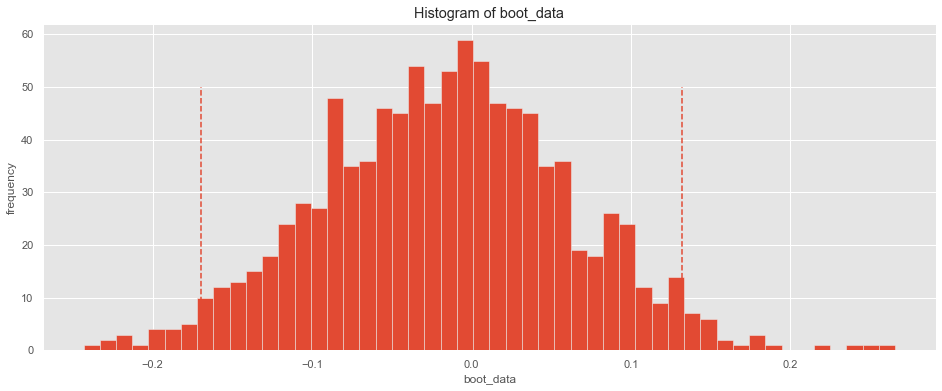

In [88]:
bootstrap_meadian=get_bootstrap(control, test, statistic = np.median)

In [89]:
bootstrap_meadian["p_value"]

0.8312833436095945

  0%|          | 0/1000 [00:00<?, ?it/s]

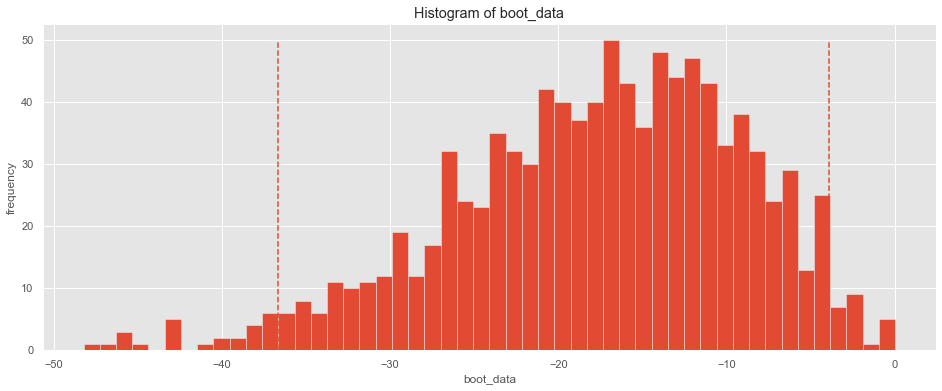

In [90]:
bootstrap_mean=get_bootstrap(control, test, statistic = np.mean)

In [91]:
bootstrap_mean["p_value"]

0.04057010896335508

In [42]:
# Теперь проверим  u-тестом

In [43]:
mannwhitneyu(control,test)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

P-value при использовании бутстрапа с np.mean < 0.05, что позволило бы отклонить нулевую гипотезу и принять альтернативную - различия между контрольной и тестовой группой статистически значимы.
Однако, P-value при использовании бутстрапа с np.median и при использовании критерия Манна-Уитни значительно больше 0.05, возникает противоречие.

Посмотрим на распределения тестовой и контрольной групп.

<AxesSubplot:>

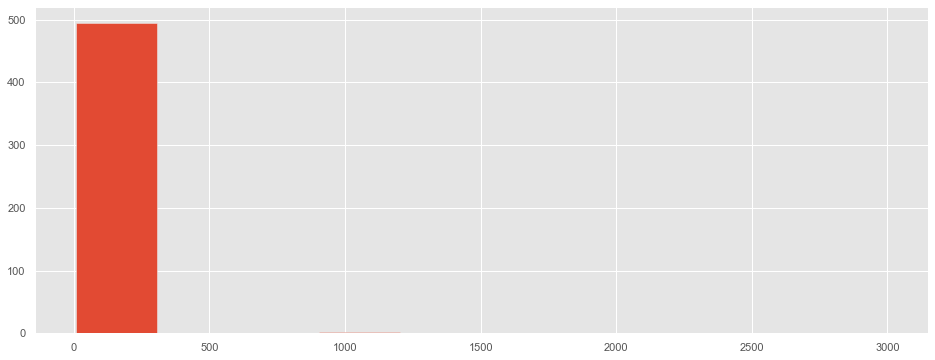

In [62]:
test.hist()

<AxesSubplot:xlabel='value', ylabel='Count'>

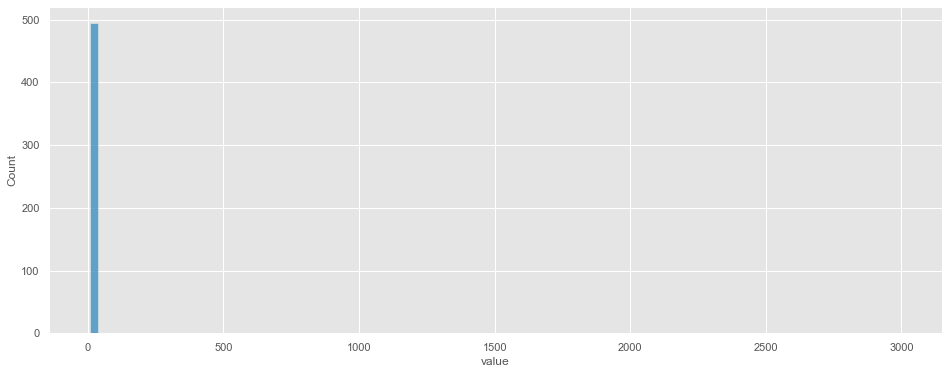

In [60]:
sns.histplot(data=testt,x='value',bins=100)

<AxesSubplot:>

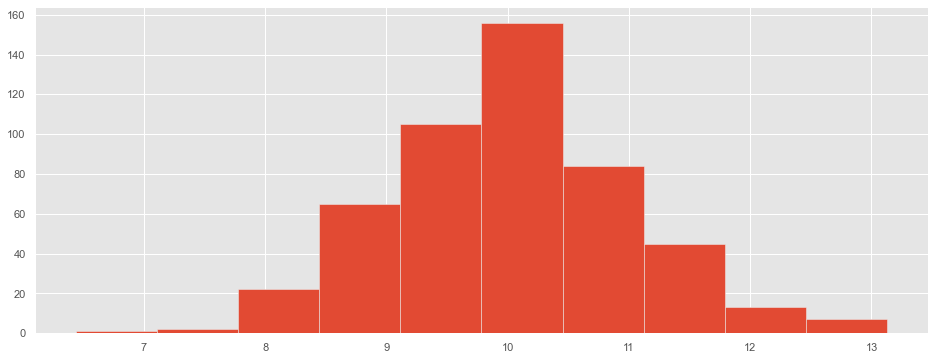

In [61]:
control.hist()

In [63]:
shapiro(control)

ShapiroResult(statistic=0.9959248900413513, pvalue=0.22416365146636963)

In [64]:
shapiro(test)

ShapiroResult(statistic=0.07038933038711548, pvalue=1.0930128021733573e-43)

In [65]:
# Контрольная группа имеет нормальное распределение, а тестов нет

In [77]:
max_control=control.max()

In [78]:
max_test

13.130345728722

In [79]:
test_without_max=test[test<max_control]

<AxesSubplot:>

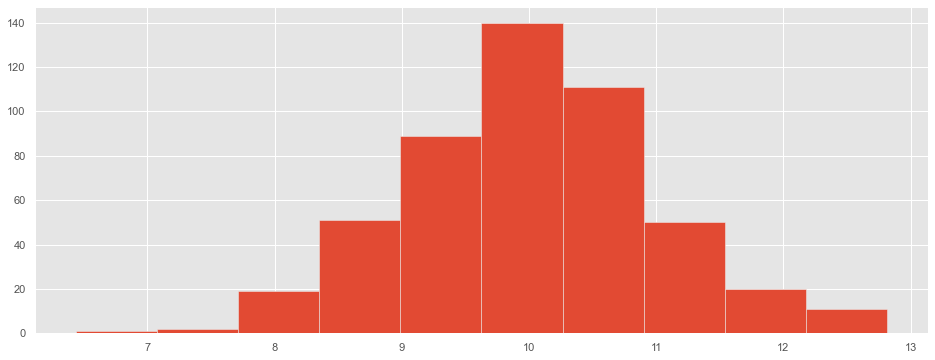

In [80]:
test_without_max.hist()

In [81]:
shapiro(test_without_max)

ShapiroResult(statistic=0.9959736466407776, pvalue=0.24110229313373566)

In [83]:
# выбросы в тестовом наборе данных
test[test > max_control]

995    1000.0
996    1200.0
997    1500.0
998    2000.0
999    3000.0
Name: value, dtype: float64

Выходит, что тестовый набор данных тоже имеет нормальное распределение, но это дело портят значительные выбросы.

  0%|          | 0/1000 [00:00<?, ?it/s]

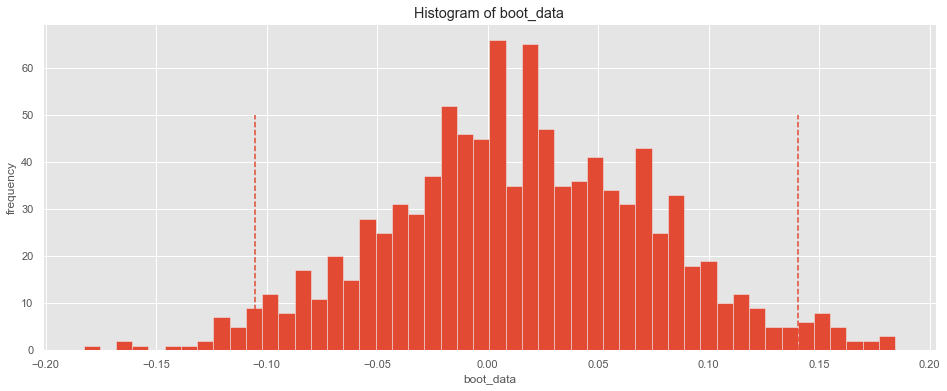

In [92]:
# бутстрап (с np.mean) с тестовыми данными без выбросов
booted_without_emissions_mean = get_bootstrap(control, test_without_max, statistic = np.mean)

In [93]:
booted_without_emissions_mean["p_value"]

0.8087540531059134

В результате при при бутстрапе с функцией np.mean получаем значение P-value очень близкое к значению при использовании функции np.median.   

Выводы, которые можно сделать: 
1. Бутстрап с функцией np.mean чувствителен к выбросам в данных.    
2. Бутстрап с функцией np.median и критерий Манна-Уитни не чувствительны к выбросам в данных.  
3. Принимаем нулевую гипотезу - статистически значимых различий между тестовой и контрольной групп нет.